Total number of samples in the dataset: 1000
Number of columns in the dataset: 11

Dataset Preview:
           Time_Stamp  Temperature (Â°C)          RPM  Fuel_Efficiency  \
0 2024-12-24 10:00:00          60.308585  3426.827588        20.445472   
1 2024-12-24 10:05:00         112.705055  2949.758424        23.083947   
2 2024-12-24 10:10:00         108.670976  1817.971040        20.555326   
3 2024-12-24 10:15:00         107.114691  2730.660539        23.226431   
4 2024-12-24 10:20:00         118.075814  1854.488677        21.148226   

   Vibration_X  Vibration_Y  Vibration_Z      Torque  Power_Output (kW)  \
0     0.874657     0.005686     0.529798  107.877659          23.367684   
1     0.696461     0.391779     0.124336   60.351655          57.941022   
2     0.495276     0.189714     0.886417  110.986564          47.732998   
3     0.986206     0.983202     0.468114   77.416793          44.112039   
4     0.710810     0.101139     0.481034  100.475881          80.681972   

   F

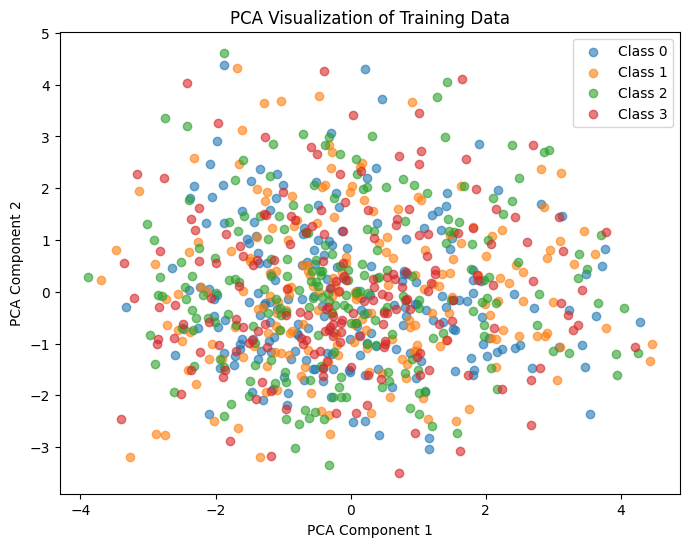


Running RandomizedSearchCV for SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters from RandomizedSearchCV (SVM):
{'C': np.float64(83.34426408004217), 'degree': 3, 'gamma': np.float64(0.010778765841014329), 'kernel': 'poly'}

Explanation of Support Vectors and Decision Boundary:
Number of Support Vectors per Class: [205 199 211 183]
Support vectors are the data points closest to the decision boundary, which define the margin of the SVM. The decision boundary is the hyperplane that maximizes the margin between classes. In a multi-class problem like this, SVM uses a one-vs-one strategy, creating a decision boundary for each pair of classes. The support vectors are critical because they determine the position and orientation of the boundary. If these points change, the boundary will shift.

Explanation of Kernel Functions:
Chosen Kernel: poly
SVM can use different kernel functions to handle non-linearly separable data by transforming it into a higher-dim

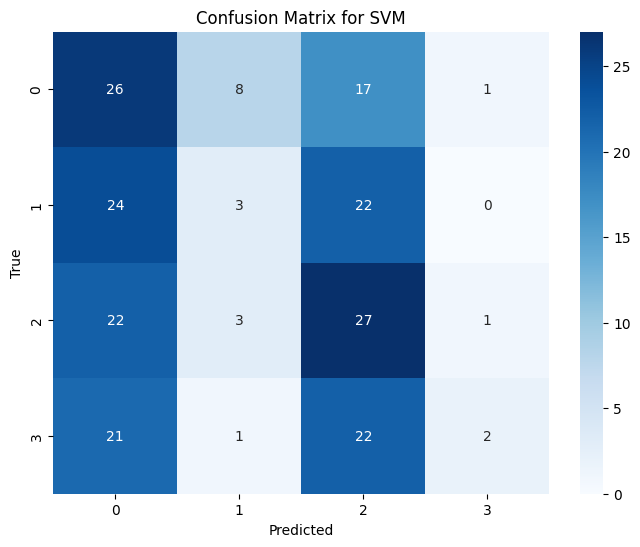


SVM Classification Report:
                precision    recall  f1-score   support

        Normal       0.28      0.50      0.36        52
   Minor Fault       0.20      0.06      0.09        49
Moderate Fault       0.31      0.51      0.38        53
  Severe Fault       0.50      0.04      0.08        46

      accuracy                           0.29       200
     macro avg       0.32      0.28      0.23       200
  weighted avg       0.32      0.29      0.24       200


Critical Analysis of Results:
1. **SVM Model Performance**:
The SVM model achieved an accuracy of 0.2900. The use of a non-linear kernel (e.g., RBF or polynomial) likely helped capture more complex patterns in the data compared to the previous linear kernel model.
2. **Impact of Using All Samples**:
Using all 1000 samples (split into 800 training and 200 test samples) provides the model with more data to learn from, which can improve generalization and accuracy, especially if the additional samples cover edge cases

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Specify the file path
file_path = 'Engine_Failure_Dataset.xlsx'

# Step 1: Load the dataset as an Excel file
try:
    data = pd.read_excel(file_path, engine='openpyxl')
except Exception as e:
    print(f"Error loading the file: {e}")
    raise

# Check the number of samples
print(f"Total number of samples in the dataset: {data.shape[0]}")
print(f"Number of columns in the dataset: {data.shape[1]}")
print("\nDataset Preview:")
print(data.head())
print("\nDataset Info:")
print(data.info())

# Check class distribution
print("\nClass Distribution of Fault_Condition:")
print(data['Fault_Condition'].value_counts(normalize=True))

# Step 2: Feature Engineering
# Create new features
data['Total_Vibration'] = np.sqrt(data['Vibration_X']**2 + data['Vibration_Y']**2 + data['Vibration_Z']**2)
data['Torque_RPM_Ratio'] = data['Torque'] / (data['RPM'] + 1e-6)  # Avoid division by zero
data['Power_Fuel_Efficiency'] = data['Power_Output (kW)'] / (data['Fuel_Efficiency'] + 1e-6)
data['Vibration_XY_Interaction'] = data['Vibration_X'] * data['Vibration_Y']

# Drop the 'Time_Stamp' column
data = data.drop('Time_Stamp', axis=1)

# Encode the categorical feature 'Operational_Mode'
label_encoder = LabelEncoder()
data['Operational_Mode'] = label_encoder.fit_transform(data['Operational_Mode'])

# Define features (X) and target (y)
X = data.drop('Fault_Condition', axis=1)
y = data['Fault_Condition']

# Step 3: Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nNumber of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Visualize the Data (using PCA for 2D visualization)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    plt.scatter(X_pca[y_train == label, 0], X_pca[y_train == label, 1], label=f'Class {label}', alpha=0.6)
plt.title('PCA Visualization of Training Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Step 6: Train the SVM Model with RandomizedSearchCV
# Define the parameter distribution
param_dist = {
    'C': uniform(0.1, 100),  # Sample C from a uniform distribution
    'kernel': ['rbf', 'poly'],  # Focus on non-linear kernels
    'gamma': uniform(0.01, 1),  # Sample gamma from a uniform distribution
    'degree': [2, 3]  # For polynomial kernel
}

# Initialize the SVM model
svm = SVC(random_state=42)

# Perform RandomizedSearchCV
print("\nRunning RandomizedSearchCV for SVM...")
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    cv=5,
    scoring='accuracy',
    n_jobs=2,
    verbose=2,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)

# Best parameters and model
print("\nBest Parameters from RandomizedSearchCV (SVM):")
print(random_search.best_params_)
best_svm = random_search.best_estimator_

# Step 7: Explain Support Vectors and Decision Boundary
print("\nExplanation of Support Vectors and Decision Boundary:")
print(f"Number of Support Vectors per Class: {best_svm.n_support_}")
print("Support vectors are the data points closest to the decision boundary, which define the margin of the SVM. The decision boundary is the hyperplane that maximizes the margin between classes. In a multi-class problem like this, SVM uses a one-vs-one strategy, creating a decision boundary for each pair of classes. The support vectors are critical because they determine the position and orientation of the boundary. If these points change, the boundary will shift.")

# Step 8: Explain Kernel Functions
print("\nExplanation of Kernel Functions:")
print(f"Chosen Kernel: {random_search.best_params_['kernel']}")
print("SVM can use different kernel functions to handle non-linearly separable data by transforming it into a higher-dimensional space:")
print("- Linear Kernel: Assumes data is linearly separable, suitable for simple relationships.")
print("- RBF Kernel: Maps data into a higher-dimensional space using a Gaussian function, effective for complex, non-linear relationships.")
print("- Polynomial Kernel: Uses a polynomial function to transform data, useful for capturing polynomial relationships.")
print(f"The best kernel ({random_search.best_params_['kernel']}) was chosen based on RandomizedSearchCV, which maximizes accuracy by testing different kernels and parameters.")

# Step 9: Evaluate the SVM Model
y_pred_svm = best_svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Test Accuracy: {accuracy_svm:.4f}")

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Minor Fault', 'Moderate Fault', 'Severe Fault']))

# Step 10: Critical Analysis of Results
print("\nCritical Analysis of Results:")
print("1. **SVM Model Performance**:")
print(f"The SVM model achieved an accuracy of {accuracy_svm:.4f}. The use of a non-linear kernel (e.g., RBF or polynomial) likely helped capture more complex patterns in the data compared to the previous linear kernel model.")
print("2. **Impact of Using All Samples**:")
print(f"Using all {data.shape[0]} samples (split into {X_train.shape[0]} training and {X_test.shape[0]} test samples) provides the model with more data to learn from, which can improve generalization and accuracy, especially if the additional samples cover edge cases or rare fault conditions.")
print("3. **Failure Cases**:")
print("From the confusion matrix, identify which classes are still being confused. For example, if Class 3 has low recall, it might indicate that the features are not sufficient to distinguish it from other classes.")
print("4. **Feature Engineering Impact**:")
print("The addition of features like Total_Vibration, Torque_RPM_Ratio, and Vibration_XY_Interaction may have helped the model better separate the classes.")
